# Resnet18 CIFAR-10

Quantize train resnet18 without PACT

In [1]:
NOQUANT_TRAIN = False
n_epochs = 200
batches = 1024

In [2]:
import argparse
import os
import shutil
import time
import pandas as pd
import matplotlib.pyplot as plt
import network.resnet_orig as resnet

from tqdm.notebook import tqdm
import time
import numpy as np
import pandas as pd
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler, RandomSampler, SequentialSampler
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau

model_names = sorted(name for name in resnet.__dict__
    if name.islower() and not name.startswith("__")
                     and name.startswith("resnet")
                     and callable(resnet.__dict__[name]))

DATA_DIR = "train"
print_freq = 50

# vit imsize
imsize = 32

In [3]:
# prepare labels
train_df = pd.read_csv("trainLabels.csv")
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
train_df['label_enc'] = le.fit_transform(train_df['label'])

# 5-fold
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

train_df["fold"] = -1
for i, (train_index, test_index) in enumerate(skf.split(train_df.id, train_df.label_enc)):
    train_df.loc[test_index, 'fold'] = i
train_df.head()

,id,label,label_enc,fold
0,1,frog,6,1
1,2,truck,9,1
2,3,truck,9,2
3,4,deer,4,1
4,5,automobile,1,2


In [4]:
class cifarDataset(Dataset):
    def __init__(self,
                 df,
                 rand=False,
                 transform=None,
                 test=False
                ):

        self.df = df.reset_index(drop=True)
        self.rand = rand
        self.transform = transform
        self.test = test

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, index):
        row = self.df.iloc[index]
        img_id = row.id
        
        images = cv2.imread(os.path.join(DATA_DIR, str(img_id)+".png"))
        
        # Load labels
        label = row.label_enc
        
        # aug
        if self.transform is not None:
            images = self.transform(image=images)['image']
              
        #images = images.astype(np.float32)
        #images /= 255
        images = images.transpose(2, 0, 1)
        
        label = label.astype(np.float32)
        #label2 = label2.astype(np.float32)
        return torch.tensor(images), torch.tensor(label),

In [5]:
import albumentations as A
import albumentations

transforms_train = albumentations.Compose([
    albumentations.ShiftScaleRotate(scale_limit=0.3, rotate_limit=180,p=0.5),
    A.Cutout(num_holes=12, max_h_size=4, max_w_size=4, fill_value=0, p=0.5),
    albumentations.Rotate(p=0.5),
    albumentations.Transpose(p=0.5),
    albumentations.VerticalFlip(p=0.5),
    albumentations.HorizontalFlip(p=0.5),   
    albumentations.Resize(imsize, imsize, p=1.0), 
    albumentations.Normalize(mean=(0.485, 0.456, 0.406),
                       std=(0.229, 0.224, 0.225), p=1),
])

transforms_val = albumentations.Compose([albumentations.Resize(imsize, imsize, p=1.0),
                                         albumentations.Normalize(mean=(0.485, 0.456, 0.406),
                       std=(0.229, 0.224, 0.225), p=1),])

/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/albumentations/augmentations/transforms.py:690: FutureWarning: This class has been deprecated. Please use CoarseDropout
  FutureWarning,


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

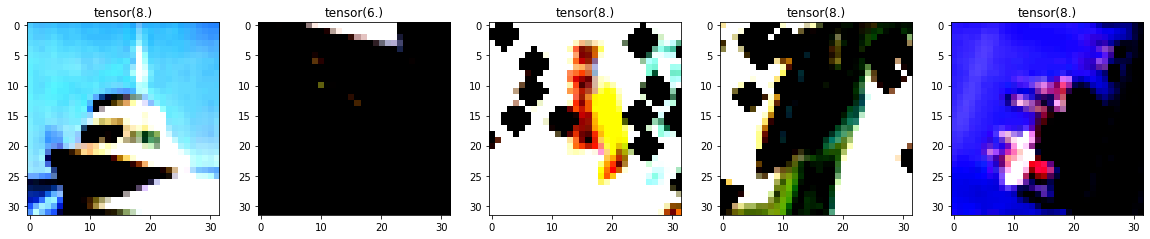

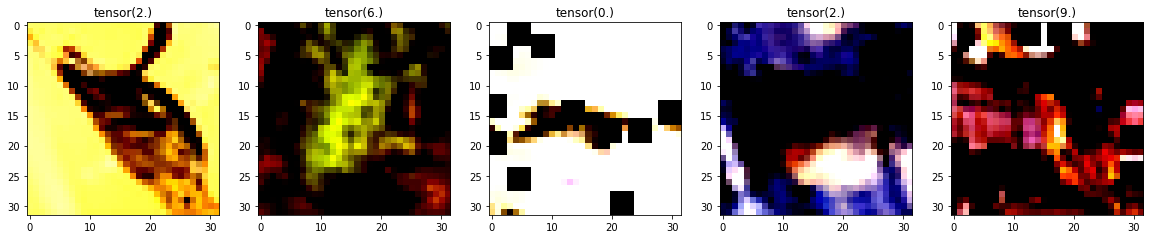

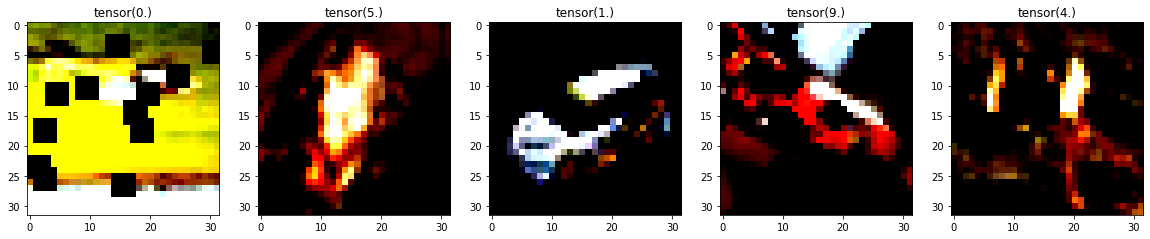

In [6]:
dataset_show = cifarDataset(train_df, transform=transforms_train)
from pylab import rcParams
rcParams['figure.figsize'] = 20,10
for i in range(3):
    f, axarr = plt.subplots(1,5)
    for p in range(5):
        idx = np.random.randint(0, len(dataset_show))
        img, label = dataset_show[idx]
        img = img.flip(0) #BGR2RGB
        axarr[p].imshow(img.transpose(0,1).transpose(1,2))
        axarr[p].set_title(str(label))
plt.show()

In [7]:
def train(train_loader, model, criterion, optimizer, epoch):
    """
        Run one train epoch
    """
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()

    # switch to train mode
    model.train()

    end = time.time()
    lambda_alpha = 0.002
    for i, (input, target) in enumerate(tqdm(train_loader)):

        # measure data loading time
        data_time.update(time.time() - end)
        target2 = target

        target = target.long().cuda()
        target2 = target2.long().cuda()
        input_var = input.cuda()
        target_var = target

        if not mixup:
          alpha = 0
        else:
          alpha = 1
        

        # compute output
        output = model(input_var)
        loss = criterion(output, target_var)

        # L2 regularization
        l2_alpha = 0.0
        for name, param in model.named_parameters():
            if "alpha" in name:
                l2_alpha += torch.pow(param, 2)
        loss += lambda_alpha * l2_alpha

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        output = output.float()
        loss = loss.float()
        # measure accuracy and record loss
        prec1 = accuracy(output.data, target)[0]
        losses.update(loss.item(), input.size(0))
        top1.update(prec1.item(), input.size(0))

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if i % print_freq == 0:
            print('Epoch: [{0}][{1}/{2}]\t'
                  'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Data {data_time.val:.3f} ({data_time.avg:.3f})\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Prec@1 {top1.val:.3f} ({top1.avg:.3f})'.format(
                      epoch, i, len(train_loader), batch_time=batch_time,
                      data_time=data_time, loss=losses, top1=top1))
    return losses.avg

def validate(val_loader, model, criterion):
    """
    Run evaluation
    """
    batch_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()

    # switch to evaluate mode
    model.eval()

    end = time.time()
    with torch.no_grad():
        for i, (input, target) in enumerate(val_loader):
            target = target.long().cuda()
            input_var = input.cuda()
            target_var = target.cuda()

            # compute output
            output = model(input_var)
            loss = criterion(output, target_var)

            output = output.float()
            loss = loss.float()

            # measure accuracy and record loss
            prec1 = accuracy(output.data, target)[0]
            losses.update(loss.item(), input.size(0))
            top1.update(prec1.item(), input.size(0))

            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()

            if i % print_freq == 0:
                print('Test: [{0}/{1}]\t'
                      'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                      'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                      'Prec@1 {top1.val:.3f} ({top1.avg:.3f})'.format(
                          i, len(val_loader), batch_time=batch_time, loss=losses,
                          top1=top1))

    print(' * Prec@1 {top1.avg:.3f}'
          .format(top1=top1))
    for name, param in model.named_parameters():
        if "alpha" in name:
            print(name, param.item())
    return top1.avg, losses.avg

def save_checkpoint(state, filename='checkpoint.pth'):
    """
    Save the training model
    """
    torch.save(state, filename)

class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res

In [8]:
train_dataset = cifarDataset(train_df[train_df.fold!=0], transform=transforms_train)
val_dataset = cifarDataset(train_df[train_df.fold==0], transform=transforms_val, test=True)

train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=batches, shuffle=True,
        num_workers=8, pin_memory=True)

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=batches, shuffle=False,
    num_workers=8, pin_memory=True)

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
from torch.autograd import Variable
from pact_utils import QuantizedLinear, QuantizedConv2d


def _weights_init(m):
    classname = m.__class__.__name__
    #print(classname)
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        init.kaiming_normal_(m.weight)

class LambdaLayer(nn.Module):
    def __init__(self, lambd):
        super(LambdaLayer, self).__init__()
        self.lambd = lambd

    def forward(self, x):
        return self.lambd(x)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, k=8, expansion=1):
        super(BasicBlock, self).__init__()
        self.k = k
        self.expansion = expansion
        self.conv1 = QuantizedConv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False, wbits=k, abits=k)
        self.bn1 = nn.BatchNorm2d(planes)
        # self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.conv2 = QuantizedConv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False, wbits=k, abits=k)
        self.bn2 = nn.BatchNorm2d(planes)
        
        if stride != 1 or in_planes != planes:
              # original resnet shortcut
              self.shortcut = nn.Sequential(
                    # nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                    QuantizedConv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False, wbits=k, abits=k),
                    nn.BatchNorm2d(self.expansion * planes)
              )
        else: # nothing done if stride or inplanes do not differ
          self.shortcut = nn.Sequential()

    def forward(self, x):
        # Relu is implemented as the input of conv2d
        out = self.bn1(self.conv1(x))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10, K=8):
        super(ResNet, self).__init__()
        self.in_planes = 32
        self.k = K

        self.conv1 = QuantizedConv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False, abits=8, wbits=8)
        self.bn1 = nn.BatchNorm2d(32)
        self.alpha1 = nn.Parameter(torch.tensor(10.))
        self.layer1 = self._make_layer(block, 32, num_blocks[0], stride=1, expansion=1)
        self.layer2 = self._make_layer(block, 64, num_blocks[1], stride=2, expansion=1)
        self.layer3 = self._make_layer(block, 128, num_blocks[2], stride=2, expansion=1)

        # self.linear = nn.Linear(64, num_classes)
        self.linear = QuantizedLinear(128, num_classes, abits=8, wbits=8)
        self.apply(_weights_init)

    def _make_layer(self, block, planes, num_blocks, stride, expansion):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride, self.k, expansion))
            self.in_planes = planes * block.expansion

        return nn.Sequential(*layers)

    def forward(self, x):
        # out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn1(self.conv1(x))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.avg_pool2d(out, out.size()[3])
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def resnet20(k=8):
    print("bit width:", k)
    return ResNet(BasicBlock, [3, 3, 3], K=k)

In [10]:
net = resnet20(8)

bit width: 8


# Train with quantization

In [ ]:
from timm.scheduler import CosineLRScheduler

for k in range(4,9):
    net = resnet20(k=k)

    model = net.cuda()
    mixup = False

    # Track experiment with wandb
    import wandb
    watermark = "resnet18_uniformquantize_k{}".format(k)

    # mess with wandb
    wandb.init(project="quantize_resnet", name=watermark)

    # define loss function (criterion) and pptimizer
    criterion = nn.CrossEntropyLoss().cuda()

    # optimizer for pact
    optimizer = torch.optim.SGD(model.parameters(), lr=1e-3,
                                momentum=0.9,
                                weight_decay=0.0002)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    scheduler = CosineLRScheduler(optimizer, t_initial=n_epochs, lr_min=1e-6, 
                          warmup_t=3, warmup_lr_init=1e-6, warmup_prefix=True)

    best_prec1 = 0
    os.makedirs("models", exist_ok=True)

    for epoch in range(n_epochs):
        scheduler.step(epoch)
        # train for one epoch
        print('current lr {:.5e}'.format(optimizer.param_groups[0]['lr']))
        tloss = train(train_loader, model, criterion, optimizer, epoch)         

        # evaluate on validation set
        prec1, valloss = validate(val_loader, model, criterion)

        # wandb
        wandb.log({'epoch': epoch, "prec":prec1, "train_loss": tloss, 'val_loss': valloss, "lr": optimizer.param_groups[0]["lr"],})

        # remember best prec@1 and save checkpoint
        is_best = prec1 > best_prec1
        best_prec1 = max(prec1, best_prec1)

        print("Best prec1 : ", best_prec1)
        if is_best:
            torch.save(model.state_dict(), os.path.join(f'models/{watermark}.pth'))

bit width: 4


wandb: Currently logged in as: arutema47. Use `wandb login --relogin` to force relogin


current lr 1.00000e-06


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [0][0/40]	Time 2.061 (2.061)	Data 1.179 (1.179)	Loss 2.9254 (2.9254)	Prec@1 10.742 (10.742)
Test: [0/10]	Time 0.628 (0.628)	Loss 2.5577 (2.5577)	Prec@1 12.988 (12.988)
 * Prec@1 11.410
alpha1 9.999961853027344
Best prec1 :  11.410000001525878
current lr 3.34000e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [1][0/40]	Time 1.562 (1.562)	Data 1.314 (1.314)	Loss 2.9409 (2.9409)	Prec@1 9.961 (9.961)
Test: [0/10]	Time 0.742 (0.742)	Loss 1.9305 (1.9305)	Prec@1 29.492 (29.492)
 * Prec@1 30.740
alpha1 9.986610412597656
Best prec1 :  30.73999990234375
current lr 6.67000e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [2][0/40]	Time 1.744 (1.744)	Data 1.495 (1.495)	Loss 2.1294 (2.1294)	Prec@1 29.102 (29.102)
Test: [0/10]	Time 0.698 (0.698)	Loss 1.8105 (1.8105)	Prec@1 34.961 (34.961)
 * Prec@1 34.530
alpha1 9.959967613220215
Best prec1 :  34.530000024414065
current lr 1.00000e-03


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [3][0/40]	Time 1.322 (1.322)	Data 1.073 (1.073)	Loss 1.9965 (1.9965)	Prec@1 34.766 (34.766)
Test: [0/10]	Time 0.731 (0.731)	Loss 1.7207 (1.7207)	Prec@1 38.672 (38.672)
 * Prec@1 38.220
alpha1 9.920103073120117
Best prec1 :  38.219999853515624
current lr 9.99938e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [4][0/40]	Time 1.442 (1.442)	Data 1.192 (1.192)	Loss 1.8982 (1.8982)	Prec@1 39.551 (39.551)
Test: [0/10]	Time 0.669 (0.669)	Loss 1.6520 (1.6520)	Prec@1 39.648 (39.648)
 * Prec@1 39.530
alpha1 9.880339622497559
Best prec1 :  39.52999993896484
current lr 9.99754e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [5][0/40]	Time 1.381 (1.381)	Data 1.132 (1.132)	Loss 1.9022 (1.9022)	Prec@1 36.719 (36.719)
Test: [0/10]	Time 0.642 (0.642)	Loss 1.5910 (1.5910)	Prec@1 42.969 (42.969)
 * Prec@1 43.220
alpha1 9.840672492980957
Best prec1 :  43.21999984130859
current lr 9.99445e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [6][0/40]	Time 1.435 (1.435)	Data 1.185 (1.185)	Loss 1.8021 (1.8021)	Prec@1 43.750 (43.750)
Test: [0/10]	Time 0.682 (0.682)	Loss 1.4659 (1.4659)	Prec@1 45.703 (45.703)
 * Prec@1 45.910
alpha1 9.801104545593262
Best prec1 :  45.90999996948242
current lr 9.99014e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [7][0/40]	Time 1.371 (1.371)	Data 1.121 (1.121)	Loss 1.6722 (1.6722)	Prec@1 45.996 (45.996)
Test: [0/10]	Time 0.679 (0.679)	Loss 1.6333 (1.6333)	Prec@1 47.559 (47.559)
 * Prec@1 42.400
alpha1 9.761632919311523
Best prec1 :  45.90999996948242
current lr 9.98460e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [8][0/40]	Time 1.619 (1.619)	Data 1.369 (1.369)	Loss 1.6702 (1.6702)	Prec@1 48.242 (48.242)
Test: [0/10]	Time 0.743 (0.743)	Loss 1.5518 (1.5518)	Prec@1 44.336 (44.336)
 * Prec@1 44.510
alpha1 9.722261428833008
Best prec1 :  45.90999996948242
current lr 9.97783e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [9][0/40]	Time 1.670 (1.670)	Data 1.420 (1.420)	Loss 1.7029 (1.7029)	Prec@1 45.312 (45.312)
Test: [0/10]	Time 0.626 (0.626)	Loss 1.4052 (1.4052)	Prec@1 50.488 (50.488)
 * Prec@1 47.620
alpha1 9.682992935180664
Best prec1 :  47.62000003051758
current lr 9.96983e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [10][0/40]	Time 1.300 (1.300)	Data 1.050 (1.050)	Loss 1.6291 (1.6291)	Prec@1 48.145 (48.145)
Test: [0/10]	Time 0.738 (0.738)	Loss 1.3979 (1.3979)	Prec@1 50.195 (50.195)
 * Prec@1 48.020
alpha1 9.643830299377441
Best prec1 :  48.02000008544922
current lr 9.96061e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [11][0/40]	Time 1.627 (1.627)	Data 1.377 (1.377)	Loss 1.7065 (1.7065)	Prec@1 46.777 (46.777)
Test: [0/10]	Time 0.691 (0.691)	Loss 1.2857 (1.2857)	Prec@1 54.492 (54.492)
 * Prec@1 52.400
alpha1 9.604776382446289
Best prec1 :  52.40000010986328
current lr 9.95017e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [12][0/40]	Time 1.223 (1.223)	Data 0.973 (0.973)	Loss 1.5363 (1.5363)	Prec@1 49.707 (49.707)
Test: [0/10]	Time 0.632 (0.632)	Loss 1.4388 (1.4388)	Prec@1 50.684 (50.684)
 * Prec@1 48.730
alpha1 9.565834045410156
Best prec1 :  52.40000010986328
current lr 9.93850e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [13][0/40]	Time 1.240 (1.240)	Data 0.991 (0.991)	Loss 1.6292 (1.6292)	Prec@1 49.316 (49.316)
Test: [0/10]	Time 0.656 (0.656)	Loss 1.3473 (1.3473)	Prec@1 54.004 (54.004)
 * Prec@1 50.830
alpha1 9.527007102966309
Best prec1 :  52.40000010986328
current lr 9.92562e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [14][0/40]	Time 1.766 (1.766)	Data 1.516 (1.516)	Loss 1.5236 (1.5236)	Prec@1 51.855 (51.855)
Test: [0/10]	Time 0.685 (0.685)	Loss 1.2944 (1.2944)	Prec@1 55.078 (55.078)
 * Prec@1 52.540
alpha1 9.488299369812012
Best prec1 :  52.54000004882813
current lr 9.91152e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [15][0/40]	Time 1.690 (1.690)	Data 1.440 (1.440)	Loss 1.5426 (1.5426)	Prec@1 50.586 (50.586)
Test: [0/10]	Time 0.629 (0.629)	Loss 1.2445 (1.2445)	Prec@1 56.543 (56.543)
 * Prec@1 54.600
alpha1 9.449712753295898
Best prec1 :  54.59999982299804
current lr 9.89622e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [16][0/40]	Time 1.347 (1.347)	Data 1.097 (1.097)	Loss 1.4983 (1.4983)	Prec@1 53.418 (53.418)
Test: [0/10]	Time 0.737 (0.737)	Loss 1.1889 (1.1889)	Prec@1 57.910 (57.910)
 * Prec@1 55.650
alpha1 9.411249160766602
Best prec1 :  55.650000042724606
current lr 9.87970e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [17][0/40]	Time 1.266 (1.266)	Data 1.016 (1.016)	Loss 1.5398 (1.5398)	Prec@1 51.660 (51.660)
Test: [0/10]	Time 0.709 (0.709)	Loss 1.2494 (1.2494)	Prec@1 56.348 (56.348)
 * Prec@1 55.440
alpha1 9.372915267944336
Best prec1 :  55.650000042724606
current lr 9.86199e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [18][0/40]	Time 1.422 (1.422)	Data 1.172 (1.172)	Loss 1.4817 (1.4817)	Prec@1 52.539 (52.539)
Test: [0/10]	Time 0.638 (0.638)	Loss 1.1332 (1.1332)	Prec@1 59.766 (59.766)
 * Prec@1 57.250
alpha1 9.334712028503418
Best prec1 :  57.250000036621095
current lr 9.84307e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [19][0/40]	Time 1.447 (1.447)	Data 1.197 (1.197)	Loss 1.3927 (1.3927)	Prec@1 53.906 (53.906)
Test: [0/10]	Time 0.770 (0.770)	Loss 1.2931 (1.2931)	Prec@1 54.785 (54.785)
 * Prec@1 54.040
alpha1 9.296646118164062
Best prec1 :  57.250000036621095
current lr 9.82296e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [20][0/40]	Time 1.375 (1.375)	Data 1.125 (1.125)	Loss 1.4264 (1.4264)	Prec@1 54.004 (54.004)
Test: [0/10]	Time 0.864 (0.864)	Loss 1.1671 (1.1671)	Prec@1 58.691 (58.691)
 * Prec@1 57.430
alpha1 9.25871467590332
Best prec1 :  57.43000009765625
current lr 9.80167e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [21][0/40]	Time 1.729 (1.729)	Data 1.480 (1.480)	Loss 1.3930 (1.3930)	Prec@1 58.105 (58.105)
Test: [0/10]	Time 0.918 (0.918)	Loss 1.1972 (1.1972)	Prec@1 59.375 (59.375)
 * Prec@1 57.020
alpha1 9.220929145812988
Best prec1 :  57.43000009765625
current lr 9.77919e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [22][0/40]	Time 1.560 (1.560)	Data 1.311 (1.311)	Loss 1.4096 (1.4096)	Prec@1 55.078 (55.078)
Test: [0/10]	Time 0.929 (0.929)	Loss 1.1796 (1.1796)	Prec@1 57.520 (57.520)
 * Prec@1 57.620
alpha1 9.183290481567383
Best prec1 :  57.61999991455078
current lr 9.75553e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [23][0/40]	Time 1.425 (1.425)	Data 1.175 (1.175)	Loss 1.3569 (1.3569)	Prec@1 57.227 (57.227)
Test: [0/10]	Time 0.891 (0.891)	Loss 1.1239 (1.1239)	Prec@1 59.863 (59.863)
 * Prec@1 58.110
alpha1 9.145798683166504
Best prec1 :  58.10999993286133
current lr 9.73070e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [24][0/40]	Time 1.609 (1.609)	Data 1.359 (1.359)	Loss 1.3648 (1.3648)	Prec@1 57.617 (57.617)
Test: [0/10]	Time 0.629 (0.629)	Loss 1.1493 (1.1493)	Prec@1 58.398 (58.398)
 * Prec@1 57.770
alpha1 9.108458518981934
Best prec1 :  58.10999993286133
current lr 9.70470e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [25][0/40]	Time 1.740 (1.740)	Data 1.490 (1.490)	Loss 1.3457 (1.3457)	Prec@1 57.031 (57.031)
Test: [0/10]	Time 0.687 (0.687)	Loss 1.0790 (1.0790)	Prec@1 62.695 (62.695)
 * Prec@1 59.670
alpha1 9.071272850036621
Best prec1 :  59.67000003051758
current lr 9.67754e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [26][0/40]	Time 1.686 (1.686)	Data 1.436 (1.436)	Loss 1.3022 (1.3022)	Prec@1 60.645 (60.645)
Test: [0/10]	Time 0.616 (0.616)	Loss 1.0343 (1.0343)	Prec@1 64.062 (64.062)
 * Prec@1 62.430
alpha1 9.034245491027832
Best prec1 :  62.429999981689456
current lr 9.64923e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [27][0/40]	Time 1.490 (1.490)	Data 1.240 (1.240)	Loss 1.3406 (1.3406)	Prec@1 57.910 (57.910)
Test: [0/10]	Time 0.685 (0.685)	Loss 1.1002 (1.1002)	Prec@1 62.402 (62.402)
 * Prec@1 59.690
alpha1 8.997376441955566
Best prec1 :  62.429999981689456
current lr 9.61978e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [28][0/40]	Time 1.535 (1.535)	Data 1.285 (1.285)	Loss 1.3325 (1.3325)	Prec@1 56.641 (56.641)
Test: [0/10]	Time 0.625 (0.625)	Loss 1.0518 (1.0518)	Prec@1 64.551 (64.551)
 * Prec@1 62.230
alpha1 8.960668563842773
Best prec1 :  62.429999981689456
current lr 9.58918e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [29][0/40]	Time 1.692 (1.692)	Data 1.442 (1.442)	Loss 1.3068 (1.3068)	Prec@1 60.840 (60.840)
Test: [0/10]	Time 0.631 (0.631)	Loss 1.0319 (1.0319)	Prec@1 63.672 (63.672)
 * Prec@1 62.160
alpha1 8.92413330078125
Best prec1 :  62.429999981689456
current lr 9.55746e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [30][0/40]	Time 1.376 (1.376)	Data 1.126 (1.126)	Loss 1.3200 (1.3200)	Prec@1 59.570 (59.570)
Test: [0/10]	Time 0.659 (0.659)	Loss 1.1722 (1.1722)	Prec@1 59.180 (59.180)
 * Prec@1 57.060
alpha1 8.887763977050781
Best prec1 :  62.429999981689456
current lr 9.52461e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [31][0/40]	Time 1.322 (1.322)	Data 1.072 (1.072)	Loss 1.2482 (1.2482)	Prec@1 61.621 (61.621)
Test: [0/10]	Time 0.743 (0.743)	Loss 1.0142 (1.0142)	Prec@1 64.941 (64.941)
 * Prec@1 63.190
alpha1 8.851572036743164
Best prec1 :  63.189999694824216
current lr 9.49065e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [32][0/40]	Time 1.442 (1.442)	Data 1.193 (1.193)	Loss 1.2303 (1.2303)	Prec@1 62.793 (62.793)
Test: [0/10]	Time 0.649 (0.649)	Loss 1.0220 (1.0220)	Prec@1 64.062 (64.062)
 * Prec@1 62.140
alpha1 8.8155517578125
Best prec1 :  63.189999694824216
current lr 9.45558e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [33][0/40]	Time 1.727 (1.727)	Data 1.476 (1.476)	Loss 1.2859 (1.2859)	Prec@1 57.715 (57.715)
Test: [0/10]	Time 0.741 (0.741)	Loss 0.9506 (0.9506)	Prec@1 63.477 (63.477)
 * Prec@1 64.560
alpha1 8.779711723327637
Best prec1 :  64.55999967041015
current lr 9.41941e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [34][0/40]	Time 1.544 (1.544)	Data 1.294 (1.294)	Loss 1.2621 (1.2621)	Prec@1 61.328 (61.328)
Test: [0/10]	Time 0.650 (0.650)	Loss 0.9639 (0.9639)	Prec@1 65.820 (65.820)
 * Prec@1 64.500
alpha1 8.744054794311523
Best prec1 :  64.55999967041015
current lr 9.38215e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [35][0/40]	Time 1.267 (1.267)	Data 1.017 (1.017)	Loss 1.2373 (1.2373)	Prec@1 60.645 (60.645)
Test: [0/10]	Time 0.627 (0.627)	Loss 1.0090 (1.0090)	Prec@1 65.820 (65.820)
 * Prec@1 63.040
alpha1 8.708582878112793
Best prec1 :  64.55999967041015
current lr 9.34381e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [36][0/40]	Time 1.618 (1.618)	Data 1.369 (1.369)	Loss 1.2254 (1.2254)	Prec@1 62.207 (62.207)
Test: [0/10]	Time 0.690 (0.690)	Loss 1.0084 (1.0084)	Prec@1 64.355 (64.355)
 * Prec@1 63.920
alpha1 8.673295974731445
Best prec1 :  64.55999967041015
current lr 9.30441e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [37][0/40]	Time 1.671 (1.671)	Data 1.421 (1.421)	Loss 1.2140 (1.2140)	Prec@1 60.938 (60.938)
Test: [0/10]	Time 0.753 (0.753)	Loss 1.0413 (1.0413)	Prec@1 64.160 (64.160)
 * Prec@1 62.250
alpha1 8.638197898864746
Best prec1 :  64.55999967041015
current lr 9.26394e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [38][0/40]	Time 1.681 (1.681)	Data 1.431 (1.431)	Loss 1.2725 (1.2725)	Prec@1 59.375 (59.375)
Test: [0/10]	Time 0.638 (0.638)	Loss 1.0261 (1.0261)	Prec@1 63.672 (63.672)
 * Prec@1 62.720
alpha1 8.603294372558594
Best prec1 :  64.55999967041015
current lr 9.22242e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [39][0/40]	Time 1.246 (1.246)	Data 0.996 (0.996)	Loss 1.2617 (1.2617)	Prec@1 61.816 (61.816)
Test: [0/10]	Time 0.759 (0.759)	Loss 0.9508 (0.9508)	Prec@1 66.602 (66.602)
 * Prec@1 65.270
alpha1 8.568586349487305
Best prec1 :  65.26999995117187
current lr 9.17986e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [40][0/40]	Time 1.522 (1.522)	Data 1.273 (1.273)	Loss 1.2279 (1.2279)	Prec@1 61.133 (61.133)
Test: [0/10]	Time 0.744 (0.744)	Loss 0.9607 (0.9607)	Prec@1 65.723 (65.723)
 * Prec@1 63.900
alpha1 8.534075736999512
Best prec1 :  65.26999995117187
current lr 9.13627e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [41][0/40]	Time 1.279 (1.279)	Data 1.029 (1.029)	Loss 1.0945 (1.0945)	Prec@1 67.578 (67.578)
Test: [0/10]	Time 0.636 (0.636)	Loss 0.9439 (0.9439)	Prec@1 66.797 (66.797)
 * Prec@1 64.260
alpha1 8.49976634979248
Best prec1 :  65.26999995117187
current lr 9.09166e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [42][0/40]	Time 1.490 (1.490)	Data 1.240 (1.240)	Loss 1.2519 (1.2519)	Prec@1 60.938 (60.938)
Test: [0/10]	Time 0.630 (0.630)	Loss 0.8944 (0.8944)	Prec@1 69.043 (69.043)
 * Prec@1 66.850
alpha1 8.46566104888916
Best prec1 :  66.84999986572265
current lr 9.04604e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [43][0/40]	Time 1.681 (1.681)	Data 1.431 (1.431)	Loss 1.2139 (1.2139)	Prec@1 63.184 (63.184)
Test: [0/10]	Time 0.626 (0.626)	Loss 0.9144 (0.9144)	Prec@1 67.090 (67.090)
 * Prec@1 66.770
alpha1 8.43175983428955
Best prec1 :  66.84999986572265
current lr 8.99942e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [44][0/40]	Time 1.747 (1.747)	Data 1.497 (1.497)	Loss 1.1820 (1.1820)	Prec@1 62.207 (62.207)
Test: [0/10]	Time 0.734 (0.734)	Loss 0.9637 (0.9637)	Prec@1 65.430 (65.430)
 * Prec@1 65.650
alpha1 8.398069381713867
Best prec1 :  66.84999986572265
current lr 8.95182e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [45][0/40]	Time 1.651 (1.651)	Data 1.401 (1.401)	Loss 1.1965 (1.1965)	Prec@1 61.914 (61.914)
Test: [0/10]	Time 0.642 (0.642)	Loss 0.9108 (0.9108)	Prec@1 68.750 (68.750)
 * Prec@1 66.740
alpha1 8.364585876464844
Best prec1 :  66.84999986572265
current lr 8.90325e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [46][0/40]	Time 1.720 (1.720)	Data 1.471 (1.471)	Loss 1.1497 (1.1497)	Prec@1 63.672 (63.672)
Test: [0/10]	Time 0.658 (0.658)	Loss 0.9215 (0.9215)	Prec@1 66.992 (66.992)
 * Prec@1 66.570
alpha1 8.331320762634277
Best prec1 :  66.84999986572265
current lr 8.85371e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [47][0/40]	Time 1.727 (1.727)	Data 1.478 (1.478)	Loss 1.1136 (1.1136)	Prec@1 64.160 (64.160)
Test: [0/10]	Time 0.645 (0.645)	Loss 0.9609 (0.9609)	Prec@1 64.941 (64.941)
 * Prec@1 65.090
alpha1 8.29826831817627
Best prec1 :  66.84999986572265
current lr 8.80323e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [48][0/40]	Time 1.275 (1.275)	Data 1.025 (1.025)	Loss 1.1280 (1.1280)	Prec@1 64.941 (64.941)
Test: [0/10]	Time 0.750 (0.750)	Loss 0.8981 (0.8981)	Prec@1 68.555 (68.555)
 * Prec@1 66.890
alpha1 8.265429496765137
Best prec1 :  66.89000008544922
current lr 8.75180e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [49][0/40]	Time 1.397 (1.397)	Data 1.147 (1.147)	Loss 1.1202 (1.1202)	Prec@1 64.648 (64.648)
Test: [0/10]	Time 0.651 (0.651)	Loss 0.9196 (0.9196)	Prec@1 66.406 (66.406)
 * Prec@1 66.450
alpha1 8.232813835144043
Best prec1 :  66.89000008544922
current lr 8.69946e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [50][0/40]	Time 1.347 (1.347)	Data 1.096 (1.096)	Loss 1.1061 (1.1061)	Prec@1 67.480 (67.480)
Test: [0/10]	Time 0.677 (0.677)	Loss 0.8978 (0.8978)	Prec@1 68.164 (68.164)
 * Prec@1 66.230
alpha1 8.20042610168457
Best prec1 :  66.89000008544922
current lr 8.64620e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [51][0/40]	Time 1.533 (1.533)	Data 1.283 (1.283)	Loss 1.1160 (1.1160)	Prec@1 65.527 (65.527)
Test: [0/10]	Time 0.717 (0.717)	Loss 0.8598 (0.8598)	Prec@1 69.141 (69.141)
 * Prec@1 67.080
alpha1 8.168262481689453
Best prec1 :  67.07999984130859
current lr 8.59204e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [52][0/40]	Time 1.263 (1.263)	Data 1.013 (1.013)	Loss 1.1026 (1.1026)	Prec@1 66.113 (66.113)
Test: [0/10]	Time 0.637 (0.637)	Loss 0.9825 (0.9825)	Prec@1 67.090 (67.090)
 * Prec@1 65.600
alpha1 8.136324882507324
Best prec1 :  67.07999984130859
current lr 8.53700e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [53][0/40]	Time 1.349 (1.349)	Data 1.100 (1.100)	Loss 1.0999 (1.0999)	Prec@1 65.820 (65.820)
Test: [0/10]	Time 0.628 (0.628)	Loss 0.8250 (0.8250)	Prec@1 70.605 (70.605)
 * Prec@1 68.510
alpha1 8.104616165161133
Best prec1 :  68.50999997558594
current lr 8.48108e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [54][0/40]	Time 1.538 (1.538)	Data 1.288 (1.288)	Loss 1.2515 (1.2515)	Prec@1 60.254 (60.254)
Test: [0/10]	Time 0.765 (0.765)	Loss 0.8198 (0.8198)	Prec@1 71.875 (71.875)
 * Prec@1 69.700
alpha1 8.073141098022461
Best prec1 :  69.69999979248047
current lr 8.42431e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [55][0/40]	Time 1.569 (1.569)	Data 1.319 (1.319)	Loss 1.0465 (1.0465)	Prec@1 68.555 (68.555)
Test: [0/10]	Time 0.722 (0.722)	Loss 0.8414 (0.8414)	Prec@1 70.703 (70.703)
 * Prec@1 69.470
alpha1 8.041898727416992
Best prec1 :  69.69999979248047
current lr 8.36670e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [56][0/40]	Time 1.544 (1.544)	Data 1.294 (1.294)	Loss 1.0657 (1.0657)	Prec@1 66.797 (66.797)
Test: [0/10]	Time 0.758 (0.758)	Loss 0.8379 (0.8379)	Prec@1 69.727 (69.727)
 * Prec@1 68.730
alpha1 8.010885238647461
Best prec1 :  69.69999979248047
current lr 8.30825e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [57][0/40]	Time 1.442 (1.442)	Data 1.192 (1.192)	Loss 1.0751 (1.0751)	Prec@1 67.383 (67.383)
Test: [0/10]	Time 0.646 (0.646)	Loss 0.8371 (0.8371)	Prec@1 70.898 (70.898)
 * Prec@1 70.000
alpha1 7.980109214782715
Best prec1 :  69.99999985351562
current lr 8.24899e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [58][0/40]	Time 1.357 (1.357)	Data 1.106 (1.106)	Loss 1.0183 (1.0183)	Prec@1 67.480 (67.480)
Test: [0/10]	Time 0.648 (0.648)	Loss 0.8914 (0.8914)	Prec@1 69.141 (69.141)
 * Prec@1 67.100
alpha1 7.9495720863342285
Best prec1 :  69.99999985351562
current lr 8.18893e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [59][0/40]	Time 1.577 (1.577)	Data 1.328 (1.328)	Loss 1.0638 (1.0638)	Prec@1 65.234 (65.234)
Test: [0/10]	Time 0.662 (0.662)	Loss 0.8731 (0.8731)	Prec@1 68.945 (68.945)
 * Prec@1 68.280
alpha1 7.919276237487793
Best prec1 :  69.99999985351562
current lr 8.12809e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [60][0/40]	Time 1.483 (1.483)	Data 1.234 (1.234)	Loss 1.1201 (1.1201)	Prec@1 62.793 (62.793)


In [ ]:
from pact_utils import TorchQuantize
len(TorchQuantize(bits=4).forward(torch.rand(1,384)).unique())

In [ ]:
net.blocks[1].mlp.fc1.forward(torch.rand(1,384).cuda()).unique()

In [ ]:
model.blocks[1].attn.qkv